In [43]:
import numpy as np

import hist

import matplotlib.pyplot as plt

## Momentum -> Measurements

In [6]:
class radius_of_curvature:
    """https://en.wikipedia.org/wiki/Gyroradius#Relativistic_case"""
    def __init__(self, magnetic_field_T):
        self.magnetic_field = magnetic_field_T # T
        
    def __call__(self, momentum_GeV, charge_electrons = 1):
        """Calculate an approximate p/(qB) in mm for the input momentum (GeV) and charge in electrons"""
        return (
            3.3
            * momentum_GeV
            / (abs(charge_electrons)*self.magnetic_field)
            * 1000 # m -> mm conversion
        )


roc = radius_of_curvature(1) # RoC in 1T magnetic field

ideal_momentum = 2 # GeV
start_pos = 0.0 # on layer 0
roc(ideal_momentum)

6600.0

In [30]:
layer_pos = np.array([0, 50, 100]) # mm

def measurements(radius, *, start_pos = 0.0, layer_positions = layer_pos):
    # assume starting position is first place we are entering the magnetic field,
    # this allows us to have our coordinates lined up easier
    return (
        start_pos
        - radius
        + np.sqrt(
            np.subtract.outer(
                radius**2,
                (layer_positions-layer_positions[0])**2
            ).T
        )
    )

In [50]:
# sample various momenta with 10% error
momenta = np.random.normal(loc=1,scale=0.10, size=100_000)*ideal_momentum
# make measurements
perfect_meas = measurements(roc(ideal_momentum))
smeared_meas = measurements(roc(momenta))
# observe change in position
delta_x = (smeared_meas.T - perfect_meas)

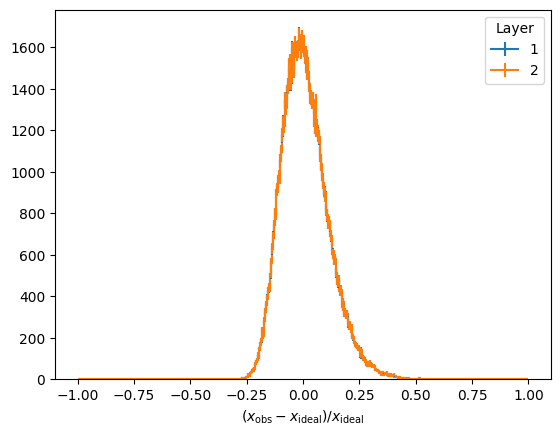

In [51]:
# going to ignore the first position since that is fixed in our "fit"
delta_x_h = (
    hist.Hist.new
    .StrCategory(['1','2'])
    .Reg(501,-1,1,label=r"$(x_\text{obs} - x_\text{ideal})/x_\text{ideal}$")
    .Double()
)
delta_x_h.fill('1',delta_x[:,1]/perfect_meas[1])
delta_x_h.fill('2',delta_x[:,2]/perfect_meas[2])
delta_x_h.plot()
plt.legend(title="Layer")
plt.show()

## Measurements -> Momentum

https://math.stackexchange.com/questions/2836274/3-point-to-circle-and-get-radius

In [66]:
def radius_from_measurements(points):
    # points indexed by [coordinate,meas,...]
    # first we shift into the coordinates where the first of the three points is at the origin
    p1 = points[:,1,...] - points[:,0,...]
    p2 = points[:,2,...] - points[:,0,...]
    x1, y1 = p1[0,...], p1[1,...]
    x2, y2 = p2[0,...], p2[1,...]
    return np.sqrt(
        (
            (x1**2*y2 - x2**2*y1 + y1**2*y2 - y2**2*y1)
            /(2*(x1*y2 - x2*y1))
        )**2 + (
            (x1**2*x2 - x2**2*x1 + y1**2*x2 - y2**2*x1)
            /(2*(x2*y1 - x1*y2))
        )**2
    )


def momentum_from_measurements(points, *, units_to_m = 1000.):
    return (
        radius_from_measurements(points) # same units as points
        / units_to_m # conversion to m
        / 3.3 # gyroradius approximate factor for (GeV, m, T, e) equation
        * 1 # T magnetic field
        * 1 # charge in electrons
    )

In [60]:
# 2GeV electron in 1T field copied from above
ideal_momentum = 2 # GeV
ideal_layer_pos = np.array([0,50,100]) # mm
ideal_measurements = np.array([ 0.        , -0.18939666, -0.75761924])
ideal_points = np.stack((ideal_measurements, ideal_layer_pos))

In [67]:
momentum_from_measurements(ideal_points)

2.000000040285226

In [82]:
def smear_position(ideal, *, num_samples = 100, u = 0.01, w = 0.1):
    return np.transpose(
        ideal * np.transpose(
            np.random.normal(
                loc=1,
                scale=(u,w),
                size=(3,num_samples,2)
            ),
            axes = (1,2,0)
        ),
        axes=(1,2,0)
    )

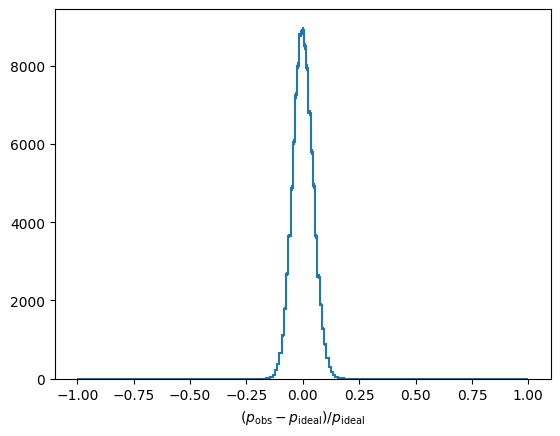

In [91]:
hist.Hist.new.Reg(201,-1,1,label=r'$(p_\text{obs}-p_\text{ideal})/p_\text{ideal}$').Double().fill(
    (
        momentum_from_measurements(smear_position(
            ideal_points,
            num_samples=100_000,
            u = 0.001,
            w = 0.01
        ))
        -ideal_momentum
    )/ideal_momentum
).plot()
plt.show()